In [1]:
#MCMC FIT TO HST DATA INCLUDING BOTH ERI II AND CLUSTER, BINNED BY 30 PIXELS, AND MASKED 
#APPROPRIATELY
#PLUMMER PROFILE FOR ERI II, SERSIC PROFILE FOR CLUSTER
#UPDATED TO FIT ALL MODEL PARAMETERS INSTEAD OF JUST RICHNESS AND CENTER POSITION
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from astropy import wcs
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
# from matplotlib.mlab import rec2csv

import emcee
import corner

# from astropy.io import ascii
import _pickle as cPickle

In [2]:
# f = fits.open('/Volumes/Spare Data/photRun0520/PISCES-II_f606w/final_drcF606W.fits')
# w = wcs.WCS(f[1].header)

In [187]:
# cat = np.genfromtxt('/Volumes/Spare Data/photRun0520/drcPhot29Apr/catDir_PISCES-II/PISCES-II_fullCat.dat',
#                     names=True)

cat = np.genfromtxt('/Volumes/Samsung_T5/photRun0520/morphology/pisces2sand.txt',
                    names=True)


In [188]:
cat.dtype.names

('ID', 'RA', 'DEC', 'gmag', 'e_gmag', 'Ag', 'mag', 'e_rmag', 'Ar', 'Obs')

In [189]:
good = np.logical_and(np.logical_and(cat['e_gmag']<=0.1,
                                     cat['e_rmag']<=0.1),
                     cat['gmag']-cat['mag']<=1)
# good = np.logical_or(cat['six_4_flag_f606w'] == 1,
#                        cat['six_4_flag_f814w'] == 1)

#                     cat['magRaw_v']<26)

# good = np.logical_and(cat['class_Star_i']>=0.8,
#                       cat['class_Star_v']>=0.8)

In [190]:
cat2 = cat[good]

In [191]:
ra = cat2['RA']
dec = cat2['DEC']
mG = cat2['gmag']
mR = cat2['mag']

# 50% at 25.75

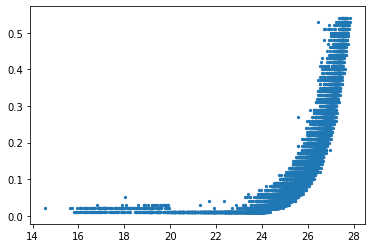

In [192]:
fig,ax = plt.subplots()

ax.scatter(cat['gmag'],cat['e_gmag'],s=5)


plt.show()

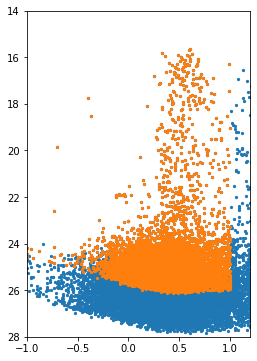

In [193]:
fig,ax = plt.subplots(figsize=(4,6))


ax.scatter(cat['gmag']-cat['mag'],cat['gmag'],s=5)
ax.scatter(cat['gmag'][good]-cat['mag'][good],cat['gmag'][good],s=5)

ax.set_ylim(28,14)
ax.set_xlim(-1,1.2)

plt.show()

In [194]:
# 344.6341667,5.9545278

ra0 = 344.6341667
dec0 = 5.9545278

In [195]:
x = np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(ra-ra0))
y = np.sin(np.deg2rad(dec)) * np.cos(np.deg2rad(dec0)) \
    - np.cos(np.deg2rad(dec)) * np.sin(np.deg2rad(dec0)) * np.cos(np.deg2rad(ra-ra0))

# in degrees now 0.2255 arcsec/pixel
# 3600 arcseconds per degree

xpix = np.rad2deg(x) * (3600/0.08)
ypix = np.rad2deg(y) * (3600/0.08)

In [196]:
x0 = 0
y0 = 0

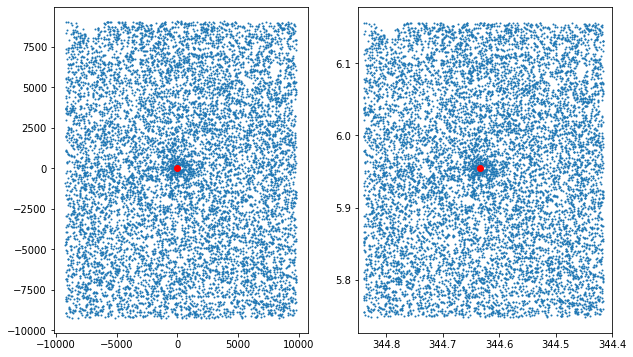

In [197]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,6))

ax1.scatter(-1*xpix,ypix,s=1)
# ax1.scatter(xT,yT,s=1)
ax1.plot(0,0,color='red',marker='o')
ax2.scatter(ra,dec,s=1)
ax2.plot(ra0,dec0,color='red',marker='o')
ax2.set_xlim(344.85,344.4)

plt.show()

In [198]:
xgood = -1*xpix[(mG<=25.75) & (mG-mR <= 1)]
ygood = ypix[(mG<=25.75) & (mG-mR <= 1)]

mGu = mG[(mG<=25.5) & (mG-mR <= 1)]
mRu = mR[(mG<=25.5) & (mG-mR <= 1)]

In [199]:
dist = np.sqrt(xgood**2 + ygood**2)

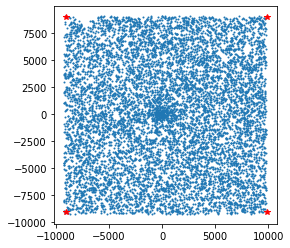

In [200]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(xgood,ygood,s=1)
ax.plot(-9100,9000,marker='*',color='red')
ax.plot(9900,9000,marker='*',color='red')
ax.plot(9900,-9100,marker='*',color='red')
ax.plot(-9100,-9100,marker='*',color='red')


plt.show()


In [201]:
#BEGIN DEFINITION OF A MASK DESCRIBING THE PORTIONS OF THE IMAGE IN WHICH THERE IS DATA
IMAGE = Path([ [-9200, 9050], 
	[9790, 9050], 
	[9790, -9200], 
	[-9200, -9200], 
	[-9200, 9050]])

# GAP = Path([ [100, 2079], 
# 	[106, 2034], 
# 	[4156, 2183], 
# 	[4151, 2231], 
# 	[100, 2079]])

IMG_BIT = 0b01
# GAP_BIT = 0b10

In [202]:
print(min(xgood))
print(max(xgood))

print(min(ygood))
print(max(ygood))

-9237.472884367164
9791.203018875982
-9254.083306890301
9062.315348892242


In [203]:
# #DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
# NBINS = 637
# XMIN,XMAX = -9300,9810
# YMIN,YMAX = -9300,9810
# XEDGE = np.linspace(XMIN,XMAX,NBINS)
# YEDGE = np.linspace(XMIN,XMAX,NBINS)

# #BIN CENTERS
# XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
# YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
# #BIN SIZE
# XDEL = XEDGE[1]-XEDGE[0]
# YDEL = YEDGE[1]-YEDGE[0]

# # Pre-calculate these instead of doing it in each evaluation of the model...
# XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


# #USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
# #REQUIRES FLATTENING THE ARRAYS
# MASK = np.zeros((NBINS-1,NBINS-1))
# image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
# # gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
# masked_indices_image = np.where(image_mask==1) # Array indices
# # masked_indices_gap = np.where(gap_mask==1) # Array indices
# MASK[masked_indices_image] = 1
# # MASK[masked_indices_gap] = 0
# IDX = np.where(MASK==1)

# #DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
# plt.imshow(MASK.T,origin='lower')

In [204]:
from scipy.stats import gaussian_kde

In [205]:
xy = np.vstack([xgood,ygood])
z = gaussian_kde(xy)(xy)

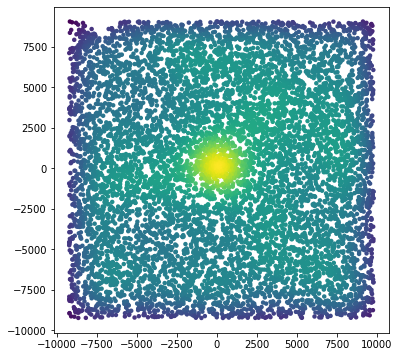

In [206]:
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(xgood,ygood, c=z, s=20, edgecolor='')
# ax.plot(0,0,color='red',ms=10,marker='*')

# hor_x0 = 2149
# hor_y0 = 2372
plt.show()


In [207]:
len(xgood)

9665

In [208]:
x0 = 0
y0 = 0
dist = np.sqrt((xgood-x0)**2 + (ygood-y0)**2)

In [209]:
# xuse = xgood[dist <= 1260]
# yuse = ygood[dist <= 1260]
xuse = xgood[dist <= 2500]
yuse = ygood[dist <= 2500]

In [210]:
len(xuse)

788

In [211]:
xy = np.vstack([xuse,yuse])
z = gaussian_kde(xy)(xy)

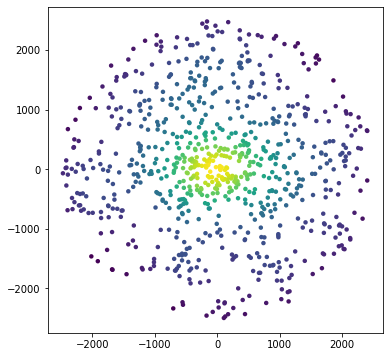

In [212]:
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(xuse,yuse, c=z, s=20, edgecolor='')
# ax.plot(0,0,color='red',ms=10,marker='*')

# hor_x0 = 2149
# hor_y0 = 2372
plt.show()


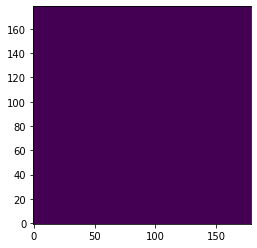

In [213]:
#DEFINE A GRID OF 30X30 PIXEL BINS COVERING THE IMAGE
NBINS = 180
XMIN,XMAX = -2700,2700
YMIN,YMAX = -2700,2700
XEDGE = np.linspace(XMIN,XMAX,NBINS)
YEDGE = np.linspace(XMIN,XMAX,NBINS)

#BIN CENTERS
XCENT = (XEDGE[1:] + XEDGE[:-1])/2.
YCENT = (YEDGE[1:] + YEDGE[:-1])/2.
#BIN SIZE
XDEL = XEDGE[1]-XEDGE[0]
YDEL = YEDGE[1]-YEDGE[0]

# Pre-calculate these instead of doing it in each evaluation of the model...
XX,YY= np.meshgrid(XCENT,YCENT,indexing='ij')


#USE THE MASKED REGIONS FROM ABOVE TO CREATE AN IMAGE MASK WITH THE APPROPRIATE BINNING
#REQUIRES FLATTENING THE ARRAYS
MASK = np.zeros((NBINS-1,NBINS-1))
image_mask = IMAGE.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
# gap_mask = GAP.contains_points(np.vstack([XX.flatten(),YY.flatten()]).T).T.reshape(XX.shape)
masked_indices_image = np.where(image_mask==1) # Array indices
# masked_indices_gap = np.where(gap_mask==1) # Array indices
MASK[masked_indices_image] = 1
# MASK[masked_indices_gap] = 0
IDX = np.where(MASK==1)

#DISPLAY THE MASK TO CHECK THAT IT'S CORRECT
plt.imshow(MASK.T,origin='lower')

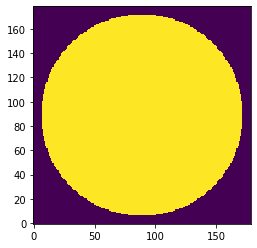

In [214]:
satstar_xcen = x0
satstar_ycen = y0
near_satstar = np.where( np.sqrt((XX - satstar_xcen)**2 + (YY - satstar_ycen)**2) > 2500)

MASK[near_satstar] = 0

plt.imshow(MASK.T,origin='lower')

In [215]:
xgood = xuse
ygood = yuse

In [216]:
#DEFINE INITIAL MODEL PARAMETERS FOR psc2 II
psc2_NSTAR = 500 
psc2_X0 = 0                  # X Center (pix)
psc2_Y0 = 0                   # Y Center (pix)
psc2_EXT = 1.12/60.               # Extension (deg) # radius in arcminutes
psc2_EXT_PIX = psc2_EXT*(3600/0.05)              # Extension (pix)
psc2_ELL = 0.33                # Ellipticity
psc2_PA = 110             # Position angle (deg)
psc2_BG = 0.001

In [217]:
psc2_EXT_PIX

1344.0

In [218]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [219]:
def data(x,y):
    """ Calculate the binned data counts. This only needs to be done
    once (not at each model evaluation), but this seemed easier to
    understand if it paralleled the model counts calculation.

    Parameters
    ----------
    x : the x coordinate of the data
    y : the y coordinate of the data

    Returns
    -------
    data_counts : the data counts in each bin
    """
    data_counts,_,_ = np.histogram2d(x,y,bins=[XEDGE,YEDGE])
    return data_counts

In [220]:
def new_kernel(x,y,lon=psc2_X0,lat=psc2_Y0,ext=psc2_EXT_PIX,ell=psc2_ELL,pa=psc2_PA):
    """ Evaluate the elliptical exponential kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    # Exponential radius (re = rh/1.68)
    r_e = ext/1.68 
    #Normalization (integrates to unity over all space) [stars/pix^2)
    norm = 1./(2*np.pi*r_e**2 * (1-ell) )

    # Exponential PDF
    pdf = norm * np.exp(-radius/r_e)

    return pdf

In [221]:
def new_kernel_plummer(x,y,lon=psc2_X0,lat=psc2_Y0,ext=psc2_EXT_PIX,ell=psc2_ELL,pa=psc2_PA):
    """ Evaluate the elliptical Plummer kernel at coordinates x,y. 
    Normalized to unity over all space...

    Parameters
    ----------
    x: x-coord for evaluating kernel [pix]
    y: y-coord for evaluating kernel [pix]
    lon: x-coord of kernel centroid [pix]
    lat: y-coord of kernel centroid [pix]
    ext: extension [pix]
    ell: ellipticity
    pa:  position angle [deg]

    Returns
    -------
    pdf : probability density (should integrate to unity over all space)
    """

    # Elliptical radius of each x,y coord
    costh = np.cos(np.radians(-pa))
    sinth = np.sin(np.radians(-pa))
    dx = x-lon
    dy = y-lat
    radius = np.sqrt(((dx*costh-dy*sinth)/(1-ell))**2 + (dx*sinth+dy*costh)**2)

    #PLUMMER SCALE RADIUS = HALF-LIGHT RADIUS 
    r_e = ext
    #Normalization (integrates to unity over all space?) [stars/pix^2)
    norm = r_e**2/(np.pi*(1-ell))

    # Plummer PDF
    pdf = norm / ((radius**2 + r_e**2)**2)

    return pdf

In [222]:
def model(theta_psc2):
    """ Calculate the binned model counts. This extends over the
    entire pixel range, but we will apply the mask later.

    Parameters
    ----------
    theta : the model parameters
    
    Returns
    -------
    model_counts : the model counts in each bin
    """
    #FIT ALL MODEL PARAMETERS
    richness = theta_psc2[0]
    kwargs = dict(lon=theta_psc2[1],lat=theta_psc2[2],ext=theta_psc2[3],ell=theta_psc2[4],pa=theta_psc2[5])
    #THIS CAN BE USED TO HOLD SOME OF THE PARAMETERS FIXED
    sigma_bg = theta_psc2[6]
    # Default values for the other parameters
    #kwargs.update(ext=ERI_EXT_PIX,ell=ERI_ELL)

    #CHANGE KERNEL CALLED HERE TO USE A DIFFERENT FUNCTIONAL FORM FOR THE SURFACE DENSITY OF THE GALAXY
    # The new kernel in pixel coordinates
    pdf = new_kernel(XX,YY,**kwargs)

#     pdf = new_kernel(XX,YY,**kwargs)

    # Calculate the model predicted counts in each pixel
    pixarea = XDEL*YDEL
    model_counts = richness * pdf * pixarea + sigma_bg
    return model_counts

In [223]:
def lnlike(theta, x, y):
    """ Likelihood function
    Parameters
    ----------
    theta : model parameter array (richness,lon,lat,ext,ell,pa)x2
    x: x-coordinate of data
    y: y-coordinate of data
    
    Returns
    -------
    lnlike: log-likelihood
    """

    #BREAK THETA UP INTO ERI II AND CLUSTER COMPONENTS
    #IF ONLY ONE COMPONENT IS BEING FIT, THEN THESE LINES ARE NOT NEEDED
    theta_psc2 = theta
    
    #commenting out to see if this will run
#     theta_cluster = theta[6:]
    
    # Calculate the data counts and model predicted counts in each pixel bin
    data_counts = data(x,y)
    model_counts_psc2 = model(theta_psc2)
    
    #ditto
#     model_counts_cluster = model_cluster(theta_cluster)
    #TO FIT A SINGLE COMPONENT, USE, E.G., MODEL_COUNTS = MODEL_COUNTS_psc2
    model_counts = model_counts_psc2 #+ model_counts_cluster

    # Apply the mask to the data and model. This selects only pixels
    # in the image for calculating the likelihood.
    data_counts_masked = data_counts[IDX]
    model_counts_masked = model_counts[IDX]
    
    # Evaluate Equation C2 from Drlica-Wagner et al. 2020 (1912.03302; ignore k! term)
    lnlike = np.sum(-model_counts_masked + data_counts_masked * np.log(model_counts_masked))
    return lnlike

In [224]:
def lnprior(theta):
    """ The log-prior. Add whatever you want here... 
    
    Parameters
    ----------
    theta : model parameters

    Returns
    -------
    lnprior : log-prior
    """
    #PRIORS FOR EACH FITTED PARAMETER
    #TO REMOVE ANY PARAMETER FROM THE FIT, REMOVE IT FROM THE LINE BELOW AND ELIMINATE THE CONSTRAINT FOR IT
    
    rich1,lon1,lat1,ext1,ell1,pa1,bg1 = theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6]

    if not (50 < rich1 < 50000):  return np.inf
    if not (-1000 < lon1 < 3500): return np.inf
    if not (-1000 < lat1 < 3500): return np.inf
    if not (500 < ext1 < 10000): return np.inf
    if not (0.05 < ell1 < 0.9): return np.inf
    if not (50 < pa1 < 150): return np.inf
    if not (0 < bg1 < 10): return np.inf

    return 0

In [225]:
def lnprob(theta, x, y):
    """ The log-probability = lnlike + lnprob 

    Parameters
    ----------
    theta : the model parameter vector
    x     : x-coord of the data
    y     : y-coord of the data
    
    Returns
    -------
    lnprob : log-probability
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y)

Running mcmc...


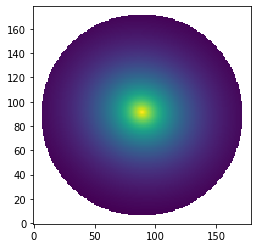

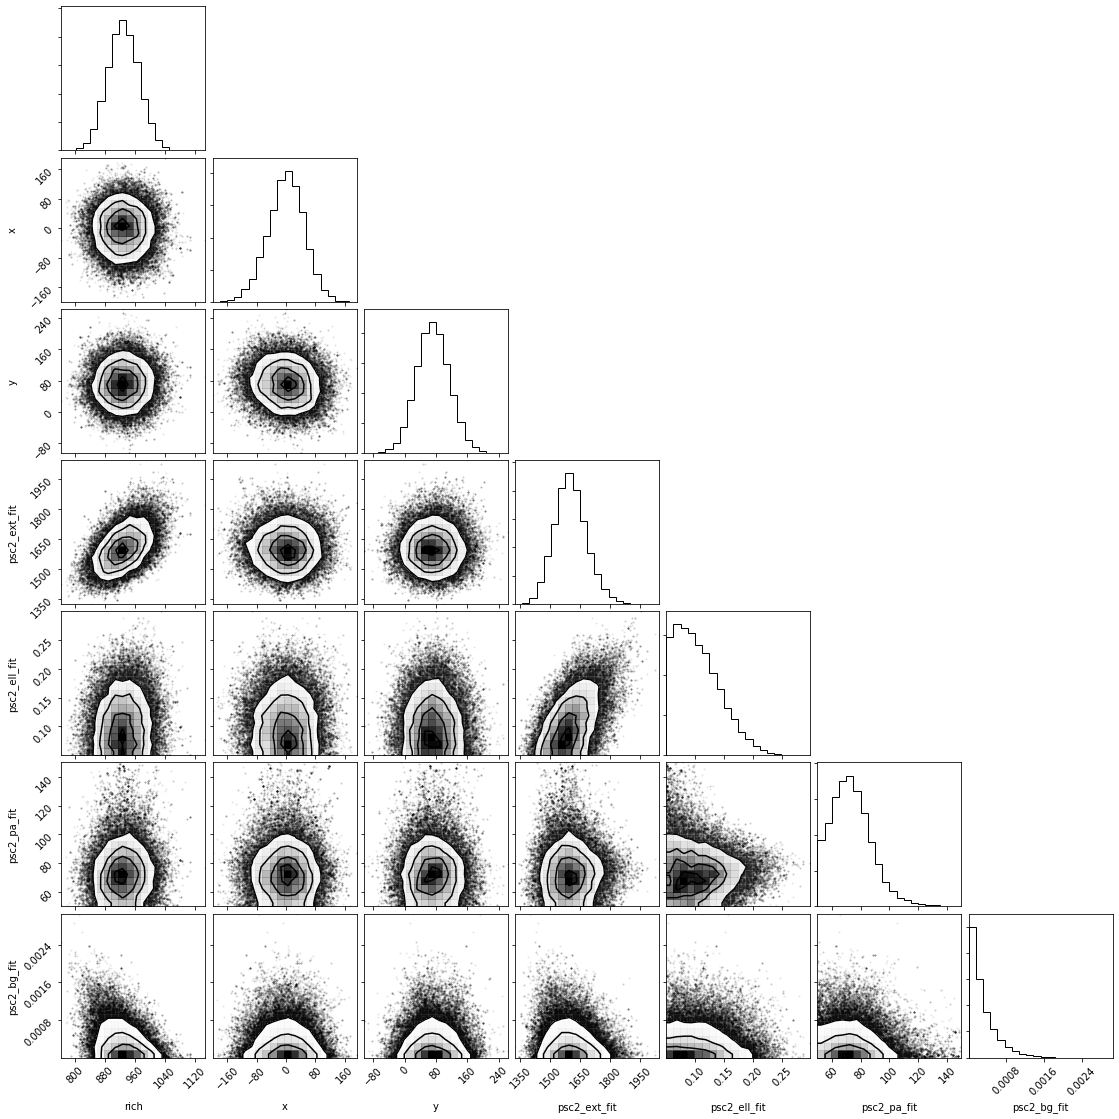

In [226]:
#FLAG FOR DISPLAYING PLOTS
do_plot=True
save_plot=True

#SET INITIAL GUESSES FOR PARAMETERS (ANY PARAMETERS NOT BEING FIT SHOULD BE REMOVED HERE)
THETA = [psc2_NSTAR,psc2_X0,psc2_Y0,psc2_EXT_PIX,psc2_ELL,psc2_PA,psc2_BG]


#PLOT (MASKED, BINNED) OBSERVED SURFACE DENSITY
if do_plot:
    # Example of the masked counts and data
    # (transpose due to difference between imshow and histogram2d...)
    data_counts = data(xgood,ygood)
    data_counts_masked = np.copy(data_counts)
    data_counts_masked[np.where(MASK==0)] = np.nan
#     out_masked_counts = data_counts_masked
    plt.imshow(data_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('data_counts_psc2e_sandFOV2500.png')
     
    
    # Initialize and run the mcmc
print("Running mcmc...")
ndim, nwalkers = len(THETA), 100
nthreads,nsamples = 16, 2000
nburn = 750
pos = [THETA + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
     
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(xgood,ygood),
                                threads=nthreads)
sampler.run_mcmc(pos,nsamples)
     
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
psc2_ext_fit,[psc2_ext_min,psc2_ext_max] = median_interval(samples[:,3])
psc2_ell_fit,[psc2_ell_min,psc2_ell_max] = median_interval(samples[:,4])
psc2_pa_fit,[psc2_pa_min,psc2_pa_max] = median_interval(samples[:,5])
psc2_bg_fit,[psc2_bg_min,psc2_bg_max] = median_interval(samples[:,6])



if do_plot:
    theta_psc2 = [rich,x,y,psc2_ext_fit,psc2_ell_fit,psc2_pa_fit,psc2_bg_fit]
    model_counts_psc2 = model(theta_psc2)
    model_counts = model_counts_psc2 
    model_counts_masked = np.copy(model_counts)
    model_counts_masked[np.where(MASK==0)] = np.nan
#PLOT (MASKED, BINNED) MODEL SURFACE DENSITY
    plt.imshow(model_counts_masked.T,origin='lower')
    if save_plot:
        plt.savefig('model_counts_psc2e_sandFOV2500.png')

#CORNER PLOT    
    fig = corner.corner(samples, labels=["rich", "x", "y", "psc2_ext_fit", "psc2_ell_fit", 
                                         "psc2_pa_fit","psc2_bg_fit"])
    if save_plot:
        fig.savefig("trianglepsc2e_sandFOV2500.png")


In [227]:
break

SyntaxError: 'break' outside loop (<ipython-input-227-6aaf1f276005>, line 4)

In [228]:
res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
       psc2_ext_fit*conv,psc2_ext_max*conv-psc2_ext_fit*conv,psc2_ext_fit*conv-psc2_ext_min*conv,
           psc2_ell_fit,psc2_ell_max-psc2_ell_fit,psc2_ell_fit-psc2_ell_min,
       psc2_pa_fit,psc2_pa_max-psc2_pa_fit,psc2_pa_fit-psc2_pa_min,
      psc2_bg_fit,psc2_bg_max-psc2_bg_fit,psc2_bg_fit-psc2_bg_min]

# print(res)

print('Rich:',rich,rich_max-rich,rich-rich_min)
print('X:',x,xmax-x,x-xmin)
print('Y:',y,ymax-y,y-ymin)
print('Ext (arcmin)',psc2_ext_fit*conv,psc2_ext_max*conv-psc2_ext_fit\
          *conv,psc2_ext_fit*conv-psc2_ext_min*conv)
print('Ell:',psc2_ell_fit,psc2_ell_max-psc2_ell_fit,psc2_ell_fit-psc2_ell_min)
print('PA:',psc2_pa_fit,psc2_pa_max-psc2_pa_fit,psc2_pa_fit-psc2_pa_min)
print('BG:',psc2_bg_fit,psc2_bg_max-psc2_bg_fit,psc2_bg_fit-psc2_bg_min)


Rich: 927.6346877414874 42.176299672336086 41.375426788995924
X: 1.4479396895311254 46.42315728620159 50.873673623234595
Y: 71.64277705329363 42.187720085506086 41.11430934057554
Ext (arcmin) 2.130590629218669 0.11044832312102937 0.10086008118457546
Ell: 0.10016097101340497 0.04579924738045503 0.033598951243148836
PA: 72.42737835629771 14.68245946162449 12.807311101512276
BG: 0.00020736078737755155 0.0003556951250924897 0.00015427459701567483


In [ ]:
cPickle.dump(samples, open( "psc2mcmc2e_sandFOV2500pl.p", "wb" ) )

In [ ]:
psc2f = cPickle.load( open( "psc2mcmc2e_sandFOV1260.p", "rb" ) )

In [ ]:
rich,[rich_min,rich_max] = median_interval(psc2f[:,0])
x,[xmin,xmax] = median_interval(psc2f[:,1])
y,[ymin,ymax] = median_interval(psc2f[:,2])
psc2f_ext_fit,[psc2f_ext_min,psc2f_ext_max] = median_interval(psc2f[:,3])
psc2f_ell_fit,[psc2f_ell_min,psc2f_ell_max] = median_interval(psc2f[:,4])
psc2f_pa_fit,[psc2f_pa_min,psc2f_pa_max] = median_interval(psc2f[:,5])
psc2f_bg_fit,[psc2f_bg_min,psc2f_bg_max] = median_interval(psc2f[:,6])

In [ ]:
# res = [rich,rich_max-rich,rich-rich_min,x,xmax-x,x-xmin,y,ymax-y,y-ymin,
#        psc2f_ext_fit*conv,psc2f_ext_max*conv-psc2f_ext_fit*conv,psc2f_ext_fit*conv-psc2f_ext_min*conv,
#            psc2f_ell_fit,psc2f_ell_max-psc2f_ell_fit,psc2f_ell_fit-psc2f_ell_min,
#        psc2f_pa_fit,psc2f_pa_max-psc2f_pa_fit,psc2f_pa_fit-psc2f_pa_min,
#       psc2f_bg_fit,psc2f_bg_max-psc2f_bg_fit,psc2f_bg_fit-psc2f_bg_min]

# print(res)

print('Rich:',rich,rich_max-rich,rich-rich_min)
print('X:',x,xmax-x,x-xmin)
print('Y:',y,ymax-y,y-ymin)
print('Ext (arcmin)',psc2f_ext_fit*conv,psc2f_ext_max*conv-psc2f_ext_fit\
          *conv,psc2f_ext_fit*conv-psc2f_ext_min*conv)
print('Ell:',psc2f_ell_fit,psc2f_ell_max-psc2f_ell_fit,psc2f_ell_fit-psc2f_ell_min)
print('PA:',psc2f_pa_fit,psc2f_pa_max-psc2f_pa_fit,psc2f_pa_fit-psc2f_pa_min)
print('BG:',psc2f_bg_fit,psc2f_bg_max-psc2f_bg_fit,psc2f_bg_fit-psc2f_bg_min)


In [ ]:
# outArr = np.array([xgood,ygood])

In [ ]:
# outArr.shape

In [ ]:
conv = 0.08/60 # pix to arcmin

In [ ]:
break

In [ ]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(data_counts_masked.T,origin='lower', cmap='viridis')

fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

In [ ]:
fig,ax = plt.subplots(figsize=(5,5))
ax.hist2d(xgood,ygood,bins=(195,195),cmap='viridis')
plt.show()

In [ ]:
cent = np.vstack((x,y))
radec = w.wcs_pix2world(cent.T,0)
print(radec)

In [ ]:
cent2 = np.vstack((344.6341667,5.9545278))
radec = w.wcs_world2pix(cent2.T,0)
print(radec)

In [ ]:
print(x0,y0)

In [ ]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(0,195)
plt.ylim(0,195)
plt.clim(-2.5,2.5)

In [ ]:
break # 336.1020000,5.4050000; 
# x0 = 2523.17585813
# y0 = 2395.41373595

In [ ]:
xbin0 = np.ones((195,1))  # (fltarr(80)+1)
xbin1 = np.ones((1,195))  
xbin1[0] = np.arange(0,195,1)
xbin2 = xbin1 * 30 + 0.5*(30)  # 67.5 pixels wide
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [ ]:
costh = np.cos(-1 * np.deg2rad(psc2_pa_fit))
sinth = np.sin(-1 * np.deg2rad(psc2_pa_fit))

dx = xbin - x0
dy = ybin - y0

In [ ]:
r1 = (dx * costh - dy * sinth) / (1 - psc2_ell_fit)
r2 = (dx * sinth + dy * costh)

radius = np.sqrt(r1**2 + r2**2)
# calculating distances to different bins in the annuli based on the PA

In [ ]:
r_h = psc2_ext_fit
# norm = r_h**2 / (np.pi * (1-psc2_ell_fit))
# # half light radius squared / (pi * 1-ell)
# pdf = norm/((radius**2 + r_h**2)**2)

#Exponential

r_e = r_h/1.68 
#Normalization (integrates to unity over all space) [stars/pix^2)
norm = 1./(2*np.pi*r_e**2 * (1-psc2_ell_fit) )

# Exponential PDF
pdf = norm * np.exp(-radius/r_e)

In [ ]:
xdel = 30
ydel = 30
pixarea = xdel*ydel  # pixel area in each bin

In [ ]:
model_counts_gal = rich*pdf*pixarea

In [ ]:
# Observed surface density map
binned_surface_density_30 = np.zeros((195,195))
for ii in range(195):
    for jj in range(195):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [ ]:
# Define annuli
radius1 = radius.flatten()
r1 = (radius1 < (0.1 * r_h)).nonzero()
r2 = ((radius1 < (0.2 * r_h)) & (radius1 >= (0.1 * r_h))).nonzero()
r3 = ((radius1 < (0.3 * r_h)) & (radius1 >= (0.2 * r_h))).nonzero()
r4 = ((radius1 < (0.4 * r_h)) & (radius1 >= (0.3 * r_h))).nonzero()
r5 = ((radius1 < (0.5 * r_h)) & (radius1 >= (0.4 * r_h))).nonzero()
r6 = ((radius1 < (0.6 * r_h)) & (radius1 >= (0.5 * r_h))).nonzero()
r7 = ((radius1 < (0.7 * r_h)) & (radius1 >= (0.6 * r_h))).nonzero()
r8 = ((radius1 < (0.8 * r_h)) & (radius1 >= (0.7 * r_h))).nonzero()
r9 = ((radius1 < (0.9 * r_h)) & (radius1 >= (0.8 * r_h))).nonzero()
r10 = ((radius1 < r_h) & (radius1 >= (0.9 * r_h))).nonzero()

In [ ]:
# areas of annuli in arcmin**2
pix_per_arcsec=20

a1 = (np.pi*(r_h*0.1)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a2 = (np.pi*(r_h*0.2)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.1)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a3 = (np.pi*(r_h*0.3)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.2)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a4 = (np.pi*(r_h*0.4)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.3)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a5 = (np.pi*(r_h*0.5)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.4)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a6 = (np.pi*(r_h*0.6)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.5)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a7 = (np.pi*(r_h*0.7)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.6)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a8 = (np.pi*(r_h*0.8)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.7)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a9 = (np.pi*(r_h*0.9)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.8)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2
a10 = (np.pi*(r_h*1.0)**2*(1-psc2_ell_fit) - np.pi*(r_h*0.9)**2*(1-psc2_ell_fit))/(pix_per_arcsec*60)**2

In [ ]:
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [ ]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf = model_counts_gal.flatten()
# model_counts_expf = model_counts_exp.flatten()
data_1d = [binned_surface_density_30f[r1].sum()/a1,
           binned_surface_density_30f[r2].sum()/a2,
           binned_surface_density_30f[r3].sum()/a3,
           binned_surface_density_30f[r4].sum()/a4,
           binned_surface_density_30f[r5].sum()/a5,
           binned_surface_density_30f[r6].sum()/a6,
           binned_surface_density_30f[r7].sum()/a7,
           binned_surface_density_30f[r8].sum()/a8,
           binned_surface_density_30f[r9].sum()/a9,
           binned_surface_density_30f[r10].sum()/a10]

model_1d = [model_counts_galf[r1].sum()/a1,
            model_counts_galf[r2].sum()/a2,
            model_counts_galf[r3].sum()/a3,
            model_counts_galf[r4].sum()/a4,
            model_counts_galf[r5].sum()/a5,
            model_counts_galf[r6].sum()/a6,
            model_counts_galf[r7].sum()/a7,
            model_counts_galf[r8].sum()/a8,
            model_counts_galf[r9].sum()/a9,
            model_counts_galf[r10].sum()/a10]


In [ ]:
# def plummer(radius,rich,r_h,ell):
    
#     # Everything needs to be in pixel units
    
#     term1 = rich / (np.pi * r_h**2 * (1-ell))
#     term2 = (1 + (radius**2/r_h**2))**(-2)
    
#     return term1 * term2

In [ ]:
# ptest = plummer(dist_x*1200,rich,psc2_ext_fit,psc2_ell_fit)

In [ ]:
def exponential(radius,rich,r_h,ell):
    
    # Everything needs to be in pixel units
    r_e = r_h/1.68
    
    term1 = rich / (2 * np.pi * r_e**2 * (1-ell))
    term2 = np.exp(-1*radius/r_e)
    
    return term1 * term2

In [ ]:
exptest = exponential(dist_x*1200,rich,psc2_ext_fit,psc2_ell_fit)

In [ ]:
bkg_add = psc2_bg_fit * (20**2) * (60**2) / 30**2

In [ ]:
fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(dist_x,data_1d,label='Data')
ax.plot(dist_x,model_1d + bkg_add,label='Exponential PDF')
ax.plot(dist_x,exptest*(1200**2)+ bkg_add,label='Exponential Function')
# ax.plot(dist_x,model_1de,label='Model Exp')
# ax.hlines(bkg_add,1e-1,3)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-1}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Psc II',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())



ax.legend()
# plt.savefig('figures/sgr2.png')
plt.show()

In [ ]:
#EXAMINE RESIDUALS NEAR THE CENTER OF THE GALAXY
plt.imshow(model_counts.T*(1-gap_mask.T)-data_counts.T*(1-gap_mask.T),origin="lower")
plt.colorbar()
plt.xlim(70,170)
plt.ylim(70,170)
plt.clim(-2.5,2.5)